# Step 1: Extract and merge walk graph and ferries graph
It extracts the walk network via OSMNX within the AOI, and then adds ferries to the network

In [208]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [209]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
from shapely.geometry import Point

In [210]:
import os, sys

In [211]:
sys.path.append(r'C:\repos\GOSTnets')
import GOSTnets as gn

In [212]:
# configuring ferry as a useful tag
ox.utils.config(useful_tags_way= [
    "bridge",
    "tunnel",
    "oneway",
    "lanes",
    "ref",
    "name",
    "highway",
    "maxspeed",
    "service",
    "access",
    "area",
    "landuse",
    "width",
    "est_width",
    "junction",
    "ferry"
])

# Extract Walk network via OSMNX

In [213]:
# import extent
cap_haitian_extent = gpd.read_file(r"input_folder/cap_haitien_study_area_w_buffer.shp")

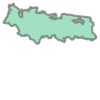

In [214]:
extent = cap_haitian_extent.geometry[0]
extent

In [215]:
# Pull in the walk network with OSMnx
%time Gwalk = ox.graph_from_polygon(extent, network_type='walk')

Wall time: 21.1 s


In [216]:
#Gwalk.graph

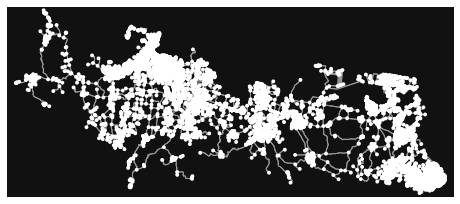

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [217]:
# Visually inspect (takes a minute or two)
ox.plot_graph(Gwalk)

## Extract Ferries over AOI
Visited https://overpass-turbo.eu/ and manually ran a query for ferries (way["ferry"]) within Cap Haitien. Detected the only ferries near Pointe Labadie, so a bounding box was manually created in QGIS that covered all of the ferries.

In [218]:
# import extent
cap_haitien_extent = gpd.read_file("input_folder/cap_haitien_ferry_extent.shp")

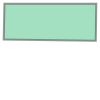

In [219]:
extent = cap_haitien_extent.geometry[0]
extent

In [220]:
walk_custom = '["ferry"]'

In [221]:
# Pull in the walk network with OSMNX
%time Gferries = ox.graph_from_polygon(extent, custom_filter=walk_custom)

Wall time: 1.33 s


In [222]:
print(nx.info(Gferries))

Name: 
Type: MultiDiGraph
Number of nodes: 6
Number of edges: 10
Average in degree:   1.6667
Average out degree:   1.6667


In [223]:
Gferries

In [224]:
Gferries.edges

OutMultiEdgeView([(616085737, 6733460125, 0), (616085737, 6970559909, 0), (616085737, 2413706127, 0), (616085737, 2413706138, 0), (616085737, 3448749786, 0), (2413706127, 616085737, 0), (2413706138, 616085737, 0), (3448749786, 616085737, 0), (6733460125, 616085737, 0), (6970559909, 616085737, 0)])

In [225]:
# test
Gferries.edges[616085737, 6733460125,0]

{'osmid': 212397499,
 'ferry': 'unclassified',
 'oneway': False,
 'length': 8474.458,
 'geometry': <shapely.geometry.linestring.LineString at 0x22c63595088>}

In [226]:
Gferries.nodes

NodeView((616085737, 2413706127, 2413706138, 3448749786, 6733460125, 6970559909))

### Add ferry nodes and edges to the walking graph

In [227]:
# add each osm node to the graph
# even if the node already exists in the graph, it won't create duplicates
for node, data in Gferries.nodes.items():
    #print(node,data)
    Gwalk.add_node(node, **data)

In [228]:
# add each osm edge to the graph
for edge, data in Gferries.edges.items():
    print(edge,data)
    Gwalk.add_edges_from([edge], **data)

(616085737, 6733460125, 0) {'osmid': 212397499, 'ferry': 'unclassified', 'oneway': False, 'length': 8474.458, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000022C63595088>}
(616085737, 6970559909, 0) {'osmid': 214459218, 'ferry': 'unclassified', 'oneway': False, 'length': 1449.198, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000022CA4F38D48>}
(616085737, 2413706127, 0) {'osmid': 233037712, 'ferry': 'unclassified', 'oneway': False, 'length': 1186.217, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000022C635959C8>}
(616085737, 2413706138, 0) {'osmid': 233037714, 'ferry': 'unclassified', 'oneway': False, 'length': 888.716, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000022C63595488>}
(616085737, 3448749786, 0) {'osmid': 337815403, 'ferry': 'unclassified', 'oneway': False, 'length': 1428.7089999999998, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000022C635951C8>}
(2413706127, 616085737, 0)

In [229]:
print(nx.info(Gwalk))

Name: 
Type: MultiDiGraph
Number of nodes: 12931
Number of edges: 34334
Average in degree:   2.6552
Average out degree:   2.6552


In [279]:
Gwalk.nodes[6770195160]

{'y': 19.7278721, 'x': -72.2057506, 'osmid': 6770195160}

In [230]:
# save again and inspect
#gn.save(Gwalk,"cap_haitien_walk_w_ferries_via_osmnx",r"temp")

## Advanced Snapping
Now we want to take our population grid vector points and use them to expand the graph. 

In [231]:
# load origins
origins = gpd.read_file(r"input_folder\cap_haitien_worldpop_pts2.shp")

### Make the node_ID really high in order to not interfere with exisiting OSMIDs from the graph

In [232]:
origins['node_ID'] = 1110000000 + origins.index
origins

,VALUE,geometry,node_ID
0,3.630365,POINT (-72.38833 19.81667),1110000000
1,3.881798,POINT (-72.38667 19.81667),1110000001
2,4.394933,POINT (-72.38250 19.81667),1110000002
3,4.479361,POINT (-72.38167 19.81667),1110000003
4,3.633273,POINT (-72.38833 19.81583),1110000004
...,...,...,...
182971,1.172181,POINT (-72.18667 19.49583),1110182971
182972,1.175843,POINT (-72.18583 19.49583),1110182972
182973,1.067793,POINT (-72.18500 19.49583),1110182973
182974,1.201748,POINT (-72.18417 19.49583),1110182974


In [233]:
# find graph utm zone
G_utm = gn.utm_of_graph(Gwalk)
G_utm

'+proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

In [288]:
# testing
# for edge, data in Gwalk.edges.items():
#     print(edge,data)

### This is the GOSTnets advanced_snap function. 

In [234]:
%%time
G2, pois_meter, new_footway_edges = gn.advanced_snap(Gwalk, origins, u_tag = 'stnode', v_tag = 'endnode', node_key_col='osmid', poi_key_col='node_ID', path=None, threshold=2000, measure_crs=G_utm)

Building rtree...
Projecting POIs to the network...
Updating internal nodes...
Updating internal edges...
Updating external links...
Remove edge projections greater than threshold: 17925/182976 (9.80%)
Missing 'from' nodes: 0
Missing 'to' nodes: 0
making a new graph from edges and nodes
Wall time: 5min 55s


In [235]:
print(nx.info(G2))

Name: 
Type: MultiDiGraph
Number of nodes: 267226
Number of edges: 542728
Average in degree:   2.0310
Average out degree:   2.0310


In [285]:
G2_edges = gn.edge_gdf_from_graph(G2)

In [289]:
#G2_edges

In [290]:
#list(G2.edges(data=True))[:10]

### save for Step 2

In [282]:
gn.save(G2,"cap_haitien_walk_w_ferries_via_osmnx_origins_adv_snap",r"temp")

In [237]:
# testing
#nodes = gn.node_gdf_from_graph(G2)

In [278]:
# testing
#G2.nodes[6770195160]

{'node_ID': 6770195160.0,
 'x': -72.2057506,
 'highway': nan,
 'y': 19.727872099999995,
 'geometry': <shapely.geometry.point.Point at 0x22dae7896c8>}

### new_poi_nodes will be used for the origin nodes when calculating an OD matrix

In [291]:
new_footway_edges.head()

,node_ID,geometry,oneway,highway,length,stnode,endnode,osmid
115073,1110000000,"LINESTRING (-72.38833 19.81667, -72.38703 19.8...",False,projected_footway,375.173768,1110000000,616755742,616755742_1110000000
115074,1110000001,"LINESTRING (-72.38667 19.81667, -72.38703 19.8...",False,projected_footway,351.525807,1110000001,616755742,616755742_1110000001
115075,1110000002,"LINESTRING (-72.38250 19.81667, -72.38670 19.8...",False,projected_footway,568.705889,1110000002,9990000000,9990000000_1110000002
115076,1110000003,"LINESTRING (-72.38167 19.81667, -72.38670 19.8...",False,projected_footway,638.748448,1110000003,9990000000,9990000000_1110000003
115077,1110000004,"LINESTRING (-72.38833 19.81583, -72.38703 19.8...",False,projected_footway,291.147256,1110000004,616755742,616755742_1110000004


#### The edges that were longer than the threshold of 2000m were already eliminated from the new_footway_edges DF, therefore we will eliminate the new_poi_nodes that don't exist in the new_footway_edges

In [257]:
# yields the elements in `list_2` that are NOT in `list_1`
elim_new_poi_nodes = np.setdiff1d(list(new_poi_nodes.node_ID),list(new_footway_edges.node_ID))

In [258]:
len(elim_new_poi_nodes)

17925

In [273]:
new_poi_nodes2 = new_poi_nodes[~new_poi_nodes['node_ID'].isin(elim_new_poi_nodes)]

In [274]:
new_poi_nodes2

,VALUE,geometry,node_ID,near_idx,near_lines,kne_idx,pp,pp_id
0,3.630365,POINT (-72.38833 19.81667),1110000000,"[3497, 3500, 3501, 3493, 3492]","3497 LINESTRING (773998.783 2192437.218, 77...",3497,POINT (773724.2960207274 2192961.415875698),9.990000e+09
1,3.881798,POINT (-72.38667 19.81667),1110000001,"[3497, 3500, 3501, 3493, 3492]","3497 LINESTRING (773998.783 2192437.218, 77...",3497,POINT (773724.2960207274 2192961.415875698),9.990000e+09
2,4.394933,POINT (-72.38250 19.81667),1110000002,"[3497, 3500, 3501, 1596, 3493]","3497 LINESTRING (773998.783 2192437.218, 77...",3497,POINT (773758.9815874682 2192951.584065732),9.990000e+09
3,4.479361,POINT (-72.38167 19.81667),1110000003,"[3497, 3500, 1596, 1597, 1598]","3497 LINESTRING (773998.783 2192437.218, 77...",3497,POINT (773758.9815874682 2192951.584065732),9.990000e+09
4,3.633273,POINT (-72.38833 19.81583),1110000004,"[3497, 3500, 3501, 3493, 3492]","3497 LINESTRING (773998.783 2192437.218, 77...",3497,POINT (773724.2960207274 2192961.415875698),9.990000e+09
...,...,...,...,...,...,...,...,...
181500,8.905331,POINT (-71.74000 19.52250),1110181500,"[15565, 15562, 15569, 15566, 15570]","15565 LINESTRING (842565.509 2162398.502, 8...",15565,POINT (842386.6844333434 2162427.225266408),NaN
181501,9.385510,POINT (-71.73917 19.52250),1110181501,"[15565, 15562, 15569, 15570, 15566]","15565 LINESTRING (842565.509 2162398.502, 8...",15565,POINT (842386.6844333434 2162427.225266408),NaN
181593,8.597751,POINT (-71.74250 19.52167),1110181593,"[15562, 15565, 15566, 15569, 15574]","15562 LINESTRING (841055.787 2162235.791, 8...",15566,POINT (841855.1933827472 2162542.305626704),NaN
181594,9.031757,POINT (-71.74167 19.52167),1110181594,"[15562, 15565, 15566, 15569, 15570]","15562 LINESTRING (841055.787 2162235.791, 8...",15565,POINT (842386.6844333434 2162427.225266408),NaN


In [275]:
new_poi_nodes2 = new_poi_nodes2[['node_ID','VALUE','geometry']]

In [277]:
# save new_nodes
new_poi_nodes2.to_csv(r"temp/origin_nodes.csv")

## Inspecting disconnected subgraphs

In [242]:
# compatible with NetworkX 2.4
list_of_subgraphs = list(G2.subgraph(c).copy() for c in nx.weakly_connected_components(G2))
max_graph = None
max_edges = 0

# To sort the list in place...
list_of_subgraphs.sort(key=lambda x: x.number_of_edges(), reverse=True)


In [280]:
for subgraph in list_of_subgraphs:
    print(len(subgraph))
    # to inspect
    gn.save(subgraph,f"{len(subgraph)}_inspect",r"temp", pickle = False, edges = True, nodes = False)

267226
